## SYS 6016 
### Project - Deep Learning for short-term forecasting of mid-price change in the stock market
### Team EC (Elena & Charu)

#### Reading in Data,Basic pre-processing,Visuals

In [1]:
# import necessary packages
import os
import pandas as pd
import numpy as np
import re
import h5py

# set options
pd.options.display.max_colwidth = 50
pd.set_option('display.max_colwidth', -1) 
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\CHARU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# see what all tickers we have
ticker_list = []
with h5py.File('./Data/Project-1-Prediction/Book_event_levelII/book_events_sip-nyse_2016-05-02.h5', 'r') as f:
    for key in f.keys():
        ticker_list.append(key)

In [3]:
len(ticker_list) # 3238 tickers

3238

In [4]:
ticker_list[0:10] # first 10 tickers

['A', 'AA', 'AAC', 'AAN', 'AAP', 'AAT', 'AAV', 'AApB', 'AB', 'ABB']

In [5]:
# read in and extract data for ticer BAC (BankOfAm)
f = h5py.File('./Data/Project-1-Prediction/Book_event_levelII/book_events_sip-nyse_2016-05-02.h5', 'r')
data = f['BAC'][:] # ticker BAC
data_ticker = data
f.close()

print(data_ticker[0:3]) # first 3 rows of the ticker data

[(1462195829805457183,    0, b'T', 14590000000, 850279, 0, b'U', 35, 524320)
 (1462195829805730729, 5561, b'A', 14590000000,    400, 0, b'B',  0,      0)
 (1462195829805730729, 5562, b'A', 14600000000,   9600, 0, b'A',  0,      0)]


In [6]:
df1 = pd.DataFrame(data_ticker) # convert to dataframe structure
df1.shape # data for BAC is 410k

(410897, 9)

In [7]:
df1.head()

,timestamp,order_id,book_event_type,price,quantity,aux_quantity,side,aux1,aux2
0,1462195829805457183,0,b'T',14590000000,850279,0,b'U',35,524320
1,1462195829805730729,5561,b'A',14590000000,400,0,b'B',0,0
2,1462195829805730729,5562,b'A',14600000000,9600,0,b'A',0,0
3,1462195829808344993,5561,b'M',14590000000,800,0,b'B',0,0
4,1462195829808556483,5561,b'M',14590000000,1100,0,b'B',0,0


In [8]:
# formatting columns

df1['book_event_type'] = df1['book_event_type'].astype(str) # convert datatype for extraction op
df1['side'] = df1['side'].astype(str)
df1['book_event_type_extr'] = df1['book_event_type'].str[2:3] # extract main character
df1['side_extr'] = df1['side'].str[2:3]
df1['timestamp_dt'] = pd.to_datetime(df1['timestamp']).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')  # convert to readable timestamp + ET timezone
df1.drop(columns = ["book_event_type","side","aux_quantity","aux1","aux2"],inplace = True) # drop unneccesary columns
df1 = df1[['order_id', 'price', 'quantity', 'book_event_type_extr', 'side_extr','timestamp_dt','timestamp']] # rearrange columns
df1.columns = ['order_id', 'price', 'qty', 'book_event_type', 'side','timestamp_dt','timestamp'] # rename
df1 = df1.sort_values(by = ['timestamp_dt','side'],ascending = True)
df1.head()

,order_id,price,qty,book_event_type,side,timestamp_dt,timestamp
0,0,14590000000,850279,T,U,2016-05-02 09:30:29.805457183-04:00,1462195829805457183
2,5562,14600000000,9600,A,A,2016-05-02 09:30:29.805730729-04:00,1462195829805730729
1,5561,14590000000,400,A,B,2016-05-02 09:30:29.805730729-04:00,1462195829805730729
3,5561,14590000000,800,M,B,2016-05-02 09:30:29.808344993-04:00,1462195829808344993
4,5561,14590000000,1100,M,B,2016-05-02 09:30:29.808556483-04:00,1462195829808556483


#### Visuals to get an idea of the health of the data
(data - ticker "BAC" only)

In [9]:
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pylab
import matplotlib.dates as mdates

In [10]:
df2 = df1 # will leave df1 as original dataframe

In [11]:
df2.head()

,order_id,price,qty,book_event_type,side,timestamp_dt,timestamp
0,0,14590000000,850279,T,U,2016-05-02 09:30:29.805457183-04:00,1462195829805457183
2,5562,14600000000,9600,A,A,2016-05-02 09:30:29.805730729-04:00,1462195829805730729
1,5561,14590000000,400,A,B,2016-05-02 09:30:29.805730729-04:00,1462195829805730729
3,5561,14590000000,800,M,B,2016-05-02 09:30:29.808344993-04:00,1462195829808344993
4,5561,14590000000,1100,M,B,2016-05-02 09:30:29.808556483-04:00,1462195829808556483


In [12]:
# extract date and hour of the day for plots
df2['day'] = df2['timestamp_dt'].dt.day
df2['time_hour'] = df2['timestamp_dt'].dt.hour

##### Total event counts in the data 

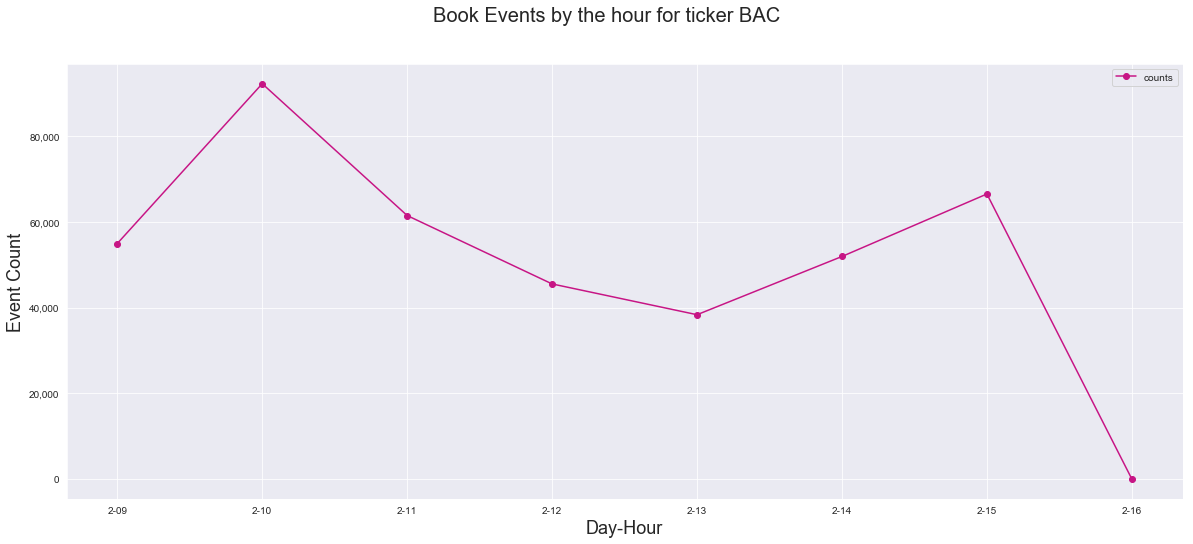

In [13]:
# Plotting total events by the hour
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

df_plot = df2.groupby(by=['day','time_hour']).size().reset_index(name="counts")
df_plot['time_hour']=df_plot['time_hour'].apply(lambda x: '{0:0>2}'.format(x))
df_plot['day_hour'] = df_plot["day"].map(str) + "-" + df_plot["time_hour"].map(str) 
df_plot = df_plot.sort_values(by=['day','time_hour'])
#df_plot.head()

# plot the trends
plt.plot('day_hour', 'counts', data=df_plot, marker='o', color='mediumvioletred')

# format plots
fig.suptitle('Book Events by the hour for ticker BAC', fontsize=20)
plt.xlabel('Day-Hour', fontsize=18)
plt.ylabel('Event Count', fontsize=18)
pylab.legend(loc='upper right')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

# display
plt.show()

# trading stars at 9am and finishes by 4pm #verified

##### Ask (A) /Bid (B) /Traded (U) book events counts 

C:\Users\CHARU\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Second argument 'B' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


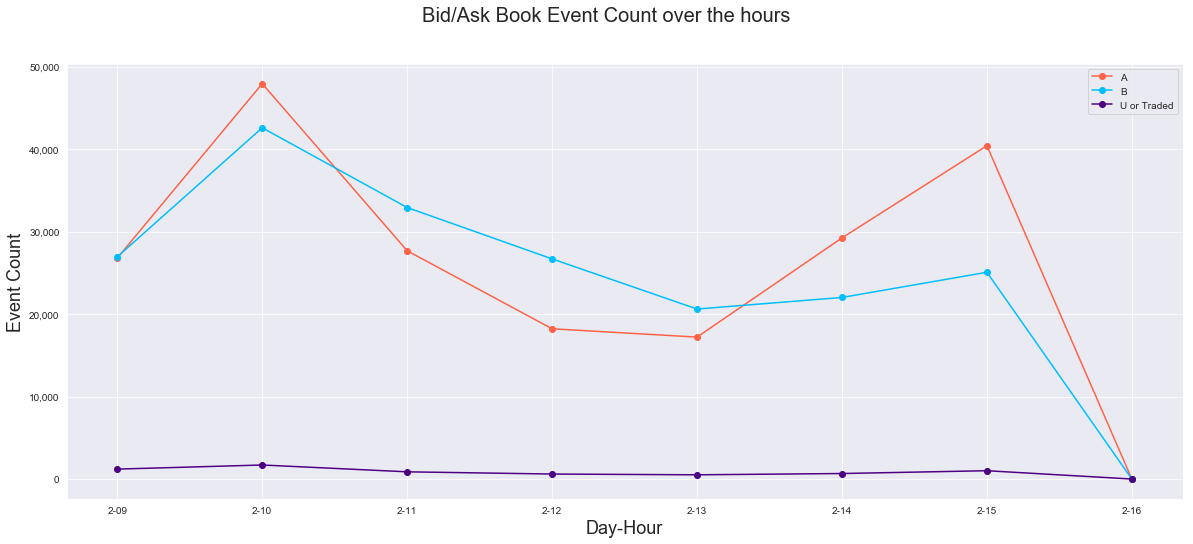

In [16]:
# Plotting

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
sns.set_style("darkgrid")

df_plot = df2.groupby(by=['day','time_hour','side']).size().reset_index(name="counts")
df_plot['time_hour']=df_plot['time_hour'].apply(lambda x: '{0:0>2}'.format(x))
df_plot['day_hour'] = df_plot["day"].map(str) + "-" + df_plot["time_hour"].map(str) 
df_plot = df_plot.sort_values(by=['day','time_hour'])
df_plot = df_plot.pivot(index='day_hour', columns='side', values='counts')
df_plot = df_plot.reset_index()
#df_plot.head()

# plot the trends
plt.plot('day_hour', 'A', data=df_plot, marker='o',color='tomato')
plt.plot('day_hour', 'B', data=df_plot, marker='o', color='deepskyblue')
plt.plot('day_hour', 'U', data=df_plot, marker='o',label="U or Traded", color='indigo')


# format plots
fig.suptitle('Bid/Ask Book Event Count over the hours', fontsize=20)
plt.xlabel('Day-Hour', fontsize=18)
plt.ylabel('Event Count', fontsize=18)
pylab.legend(loc='upper right')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))


# display
plt.show()